In [1]:
#import packages and formatting statements

import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.table import Table
import os, sys
sys.path.append('./Python')
from FindNearestHIIRegion import nearestHII

plt.rc('text',usetex=False)
fontsize=10
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [2]:
# Compile galaxy and sne data
data = Table.read('../Data/1.GroupedSampleData.csv', format='csv')

data[0:1]


col0,galaxy,distance,gal_ra,gal_dec,pos_ang,incl,nat_res,r_eff,maps_musedap,maps_nat,maps_150,maps_1kpc,maps_HII,maps_irac,maps_CO21,maps_eCO21,maps_ext,maps_vdisp,maps_HST,JWST200,JWST300,JWST335,JWST360,JWST770,JWST1000,JWST1130,JWST2100,sn_name,sn_type,sn_ra,sn_dec
int64,str7,float64,float64,float64,float64,float64,float64,float64,str71,str58,str64,str63,str50,str40,str72,str73,str36,str32,str41,str93,str93,str93,str93,str93,str94,str94,str94,str82,str50,str127,str132
0,NGC1087,15.85,41.60492,-0.498717,359.1,42.9,0.92,42.091877,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_150pc.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_1kpc.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_emom0.fits,../Data/SFR_v1/NGC1087_MAPS_sfr.fits,../Data/vdisp/ngc1087_vdisp.fits,../../GalaxyFiles/HST/ngc1087_hst_ha.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F200W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F300W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F330W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F365W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F770W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F1000W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F1130W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087_F2100W_atGauss7p5_anchored.fits,['SN1995V'],['II'],[41.61152777777777],[-0.4987861111111111]


In [3]:
# prepare lists for nearest HII method

centerCoords = [(float(data["gal_ra"][i]), float(data["gal_dec"][i])) for i in range(len(data))] 
    
sn_ras, sn_decs, sn_names = [],[],[]
for i in range(len(data)):
    sn_ras.append(data["sn_ra"][i][1:-1].replace(",","").split(" "))
    sn_decs.append(data["sn_dec"][i][1:-1].replace(",","").split(" "))
    sn_names.append(data["sn_name"][i][1:-1].replace(",","").replace("'","").split(" "))

for i in range(len(sn_ras)):
    sn_ras[i] = [float(ele) for ele in sn_ras[i]]
    sn_decs[i] = [float(ele) for ele in sn_decs[i]]
    
# manually clean names array to group peculiar SNe into specified classes.    
sn_types = ['II', 'II', 'Ia', 'II', 'SESNe', 'Unclassified', 'II', 'Ia', 'Ia', 'II', 'II', 'SESNe', 'II', 'Ia', 'II', 'II', 'II', 'II', 'II', 'II', 'SESNe', 'II', 'II', 'II', 'II', 'II', 'II', 'Ia', 'Ia', 'Unclassified', 'Unclassified', 'SESNe', 'SESNe']


In [4]:
# Find nearest HII region for each SN
in_HII, nearHII, HIIra, HIIdec, sn_hii_name, hii_vals = [],[],[],[],[],[]

for i in range(len(data["galaxy"])):
    if os.path.isfile(data["maps_nat"][i]) and os.path.isfile(data["maps_HII"][i]):

        # find nearest HII regions to each SN in galaxy
        inHII, near, ra, dec, hii_val = nearestHII(data["galaxy"][i], data["maps_HII"][i], 0, centerCoords[i], float(data["pos_ang"][i]), 
                                   float(data["incl"][i]), float(data["distance"][i]), sn_ras[i], sn_decs[i])

    for j in range(len(near)):
        sn_hii_name.append(sn_names[i][j])
        in_HII.append(inHII[j])
        nearHII.append(near[j])
        HIIra.append(ra[j])
        HIIdec.append(dec[j])
        hii_vals.append(hii_val[j])


# print(nearHII, HIIra, HIIdec)


In [5]:
# clean up distances array and assign 0.1 in place of zero so we can plot in logscale
hii_dists = []

for i in range(len(nearHII)):
    if nearHII[i] < 0.1:
        val = 0.1
    else:
        val = nearHII[i].item()
    hii_dists.append(val)
        

In [6]:
# separate the SNe by type
IInear, Ianear, Ibcnear, Uncnear = [],[],[],[]

for i in range(len(sn_types)):
        if "Ia" in sn_types[i]:
            Ianear.append(nearHII[i])
        elif "II" in sn_types[i]:
            IInear.append(nearHII[i])
        elif ("SESNe" in sn_types[i]):
            Ibcnear.append(nearHII[i])
        else:
            Uncnear.append(nearHII[i])
        
Ia_med = np.median(np.hstack(Ianear))
II_med = np.median(np.hstack(IInear))
Ibc_med = np.median(np.hstack(Ibcnear))
Unc_med = np.median(np.hstack(Uncnear))


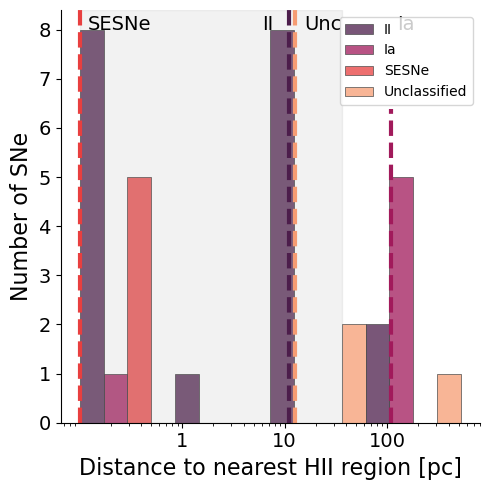

In [7]:
colors = sns.color_palette("rocket", 4)
sns.set_palette(colors)
f, ax = plt.subplots(figsize=(5, 5))
sns.despine(f)

sns.histplot(
    x=hii_dists, hue=sn_types,
    multiple="dodge",     
    bins=4,
#     palette="rocket",
    edgecolor=".3",
#     kde=True,
    linewidth=.5,
    log_scale=True,
    
)
ax.axvline(Ia_med,0,.76, ls="--", color=colors[1], linewidth=3)
ax.text(Ia_med+15,8,"Ia", fontsize=14)
ax.axvline(0.1,0,10, ls="--", color=colors[2], linewidth=3)
ax.text(0.12,8,"SESNe", fontsize=14)
ax.axvline(II_med,0,10, ls="--", color=colors[0], linewidth=3)
ax.text(II_med-5,8,"II", fontsize=14)
ax.axvline(Unc_med,0,10, ls="--", color=colors[3], linewidth=3)
ax.text(Unc_med+3,8,"Unc", fontsize=14)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1,10, 100, 1000])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.axvspan(0.1,36.36,color='grey',alpha=0.1)
ax.set_ylabel("Number of SNe", fontsize=16)
ax.set_xlabel("Distance to nearest HII region [pc]", fontsize=16)
plt.tight_layout()
plt.savefig("../Figures/HIIdistHistKDE.png", dpi=300)
plt.show()
plt.close()

/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89526/4229354993.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


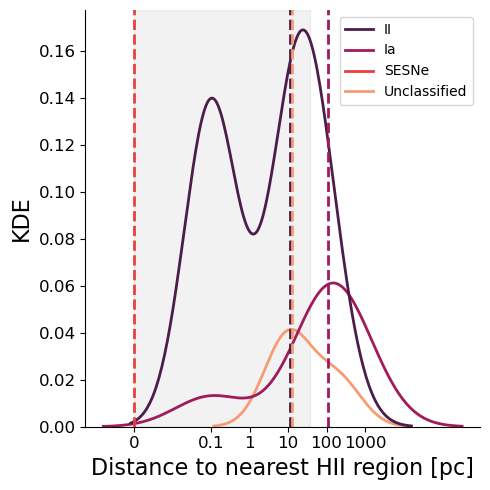

In [8]:
colors = sns.color_palette("rocket", 4)
sns.set_palette(colors)

f, ax = plt.subplots(figsize=(5, 5))
sns.despine(f)

sns.kdeplot(
    x=hii_dists, hue=sn_types,
    linewidth=2,
    log_scale=True,    
)
ax.axvline(Ia_med,0,10, ls="--", color=colors[1], linewidth=2)
# ax.text(Ia_med+15,0.1,"Ia", fontsize=14)
ax.axvline(0.001,0,10, ls="--", color=colors[2], linewidth=2)
# ax.text(0.12,8,"SESNe", fontsize=14)
ax.axvline(II_med,0,10, ls="--", color=colors[0], linewidth=2)
# ax.text(II_med-5,8,"II", fontsize=14)
ax.axvline(Unc_med,0,10, ls="--", color=colors[3], linewidth=2)
# ax.text(Unc_med+3,8,"Unc", fontsize=14)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([0.001,0.1,1,10, 100, 1000])
ax.set_xticklabels(["0","0.1","1", "10", "100", "1000"])
# ax.sex_xlim([0.1,1000])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvspan(0.001,36.36,color='grey',alpha=0.1)
ax.set_ylabel("KDE", fontsize=16)
ax.set_xlabel("Distance to nearest HII region [pc]", fontsize=16)
plt.tight_layout()
plt.savefig("../Figures/HIIdistHistKDE.png", dpi=300)
plt.show()
plt.close()

In [9]:
print(II_med)
print(Unc_med)
print(Ia_med)

11.063830000808956
12.603072150814626
110.09639203983784


In [10]:
distances = Table({"sn_name"  : sn_hii_name,
                    "sn_type" : sn_types,
                    "in_HII"  : in_HII,
                    "hii_dist": hii_dists,
                    "hii_val" : hii_vals})

distances.write("../Data/sn_hii_dists.csv", format = "csv", overwrite = True)

distances[0:1]


sn_name,sn_type,in_HII,hii_dist,hii_val
str11,str12,str3,float64,int32
SN1995V,II,Yes,0.1,731
